### 高斯分布与最大似然估计
$$ p(x)\ =\ \frac{1}{(2\pi)^{d/2}\vert \Sigma \vert ^{1/2}}exp[-\frac{1}{2}(x-\mu)^T\Sigma^{-1}(x-\mu)] $$
如果我们希望用一个高斯分布去逼近数据分布，则目标就是最小化NLLLoss(负对数似然损失)。
$$ Loss(\mu,\Sigma) = -\sum_i^N log(p(x|\mu,\Sigma))= C+\frac{N}{2}log|\Sigma|+\frac{1}{2}\sum_i^N(x_i-\mu)^T\Sigma^{-1}(x_i-\mu)
$$
这个问题的性质非常好，是一个凸优化问题，我们求参数mu和sigma的偏导数并让它为0，就得到最优的参数估计量。
$$ \frac{\partial L} {\partial \mu} = -\sum_i^N\Sigma^{-1}x_i+N\Sigma^{-1}\mu $$
$$ \frac{\partial L} {\partial \Sigma} = \frac{1}{2}(N\Sigma^{-1}-\Sigma^{-1}\sum_i^{N}
    (x_i-\mu)(x_i-\mu)^T\Sigma^{-1})^T $$
令偏导为0，就得到非常好看的闭式解形式。mu的最佳估计是样本均值，sigma是样本协方差矩阵。
$$ \hat\mu = \frac{1}{N}\sum_{i=1}^Nx_i = \bar x $$
$$ \hat\Sigma = \frac{1}{N}\sum_{i=1}^N(x_i-\mu)(x_i-\mu)^T $$

**异常检测系统**  
多元高斯分布可以fit一个真实的数据分布，我们可以用高斯分布良好的性质，用数据在高斯分布中计算得到的概率，作为该数据的异常评估标准。  
比如这里示范一个简单的例子，我们用iris的1、2类别作为正常样本，训练一个高斯分布。并用0类别样本测试，观察两者的概率分布区别。

In [1]:
import numpy as np
import copy
import matplotlib.pyplot as plt
import matplotlib
import random
import scipy.stats as stats
from sklearn import datasets
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [2]:
def Gaussian(x,mu,sigma):
    d = len(x)
    x = (x-mu)[np.newaxis,:]
    numerator = np.exp(-0.5*x.dot(np.linalg.inv(sigma)).dot(x.T))
    denumerator = ((2*np.pi)**(d/2)) * (np.linalg.det(sigma)**0.5)
    return numerator/denumerator

X,y = datasets.load_iris(return_X_y=True)

In [3]:
X_normal = X[50:]
X_abnormal = X[:50]
mu = np.mean(X_normal,axis = 0)
N = len(X_normal)
sigma = sum((X_normal[j]-mu).reshape(-1,1).dot((X_normal[j]-mu).reshape(1,-1))
                       for j in range(N))/N

In [4]:
import seaborn as sns

prob_normal = [Gaussian(x,mu,sigma)[0,0] for x in X_normal]
prob_abnormal = [Gaussian(x,mu,sigma)[0,0] for x in X_abnormal]

print("Max probability of anomaly: %.8f"%max(prob_abnormal))
print("Min probability of normal: %.8f"%min(prob_normal))

Max probability of anomaly: 0.00001055
Min probability of normal: 0.00240223


从上面的最大最小可以看出，异常样本在高斯分布中会分配到非常小的概率值，而正常样本中即使存在稍微偏离分布的样本点，概率也不会太低。我们可以很容易的用这个方法检测异常的样本。

### 高斯之上
只用高斯分布并不总能很好的实现数据分布的建模，为此我们可以用多个高斯模型的混合来进行更细腻的拟合。设高斯分布为$\Phi$，则
$$ p(x|\theta) = \sum_k^K \alpha_k \phi(x|\theta_k)  $$
$$ log(L(\theta)) = \sum_j^N log(p(x|\theta)) = \sum_j^N log(\sum_k^K\alpha_k \phi(x|\theta_k)) $$
其中alpha是归一化系数，为了让概率密度函数积分后是1，所有alpha的总和是1.  
我们有了这种更好的分布函数后，就可以用它来逼近数据分布了。但是相当重要的一点是，因为每个小模型都含有alpha的系数，像上面那样求导后得到的对参数mu和sigma的偏导都会含有alpha系数，然而alpha的偏导又含有mu和sigma，而且alpha还有$\sum \alpha = 1$的约束。这就让我们没法得到上面那样的漂亮的闭式解，为此我们有另一种迭代的算法来帮助我们求解，这个算法称作EM算法，用于含有隐变量（Hidden variable）的概率模型参数的最大似然估计。

### EM algorithm
EM算法的数学内涵涉及到对隐变量求边缘积分和损失下界的极大化，这部分超纲了，我们就只讲直观一点的算法理解。  
一开始我们并不知道隐变量参数$\mu,\Sigma,\alpha$的值，但我们可以随机初始化一组参数。然后对混合模型求$\mu_i$的偏导，令它等于0得到的等式是
$$ \sum_i^N \frac{\alpha_i \phi(x_j|\mu_i,\Sigma_i)}{\sum_k^K\alpha_k \phi(x_j|\mu_k,\Sigma_k)}(x_j-\mu_i)=0 $$
这个式子难解是因为它左边的那项掺了$\alpha$ ，所以不好写闭式解。但是如果我们能给定一个初始迭代点，把左边那项算出来=C，再把C代入等式，就能算出一个假的解。事实上，左边那项就是第j个样本出自第i个高斯簇的后验概率 $$\gamma_{ij} = \frac{\alpha_i \phi(x_j|\mu_i,\Sigma_i)}{\sum_k^K\alpha_k \phi(x_j|\mu_k,\Sigma_k)} $$
$$ \sum_j^N \gamma_{ij} (x_j-\mu_i) = 0 $$
$$ \mu_i = \frac{\sum_j^N \gamma_{ij} x_j}{\sum_j^N \gamma_{ij}} $$
参考上面的流程，对sigma和alpha求偏导，类似地可以算出来
$$ \Sigma_i = \frac{\sum_j^N \gamma_{ij} (x_j-\mu_i)(x_j-\mu_i)^T}{\sum_j^N \gamma_{ij}} $$
$$ \sum_i^K \sum_j^N \gamma_ij = N = N\sum_i^K \alpha_i $$
$$ \alpha_i = \frac{\sum_j^N \gamma_{ij}}{N} $$
这个解能用于迭代的前提是，每次迭代都会让我们的损失函数NLL loss下降，也就是让对数似然上升，这种迭代算法才具有收敛性和可行性。这个证明实际上是很困难的，我们需要对约束的最优化问题构造下界函数Q(上面的gamma就是Q函数的一部分)，然后通过优化下界函数来更新参数。我们只需要把这种方法理解为坐标下降即可，每次固定一部分参数，让一个参数向着能让loss降低的方向更新。  
上面的算法总结为**EM算法（Expectation-maximization）**，具体如下  
**E-step**: 计算数据点在当前模型的期望，得到隐变量的概率分布  
**M-step**: 使用最大似然估计更新隐变量的值到新的迭代点。  
很重要的一点是，这个问题中构造的NLL loss不是凸优化，因此EM得到的解不保证是最优解，一般我们会尝试不同的初始化策略来找到一个好的解。  

### 几何理解
把$\gamma$视为每个高斯分布对样本的重要程度，算法其实比较直观。在迭代过程中，我们首先更改的是高斯分布的均值(聚类中心)$\mu$。上面的算法告诉我们，我们在更新$\mu_i$时，应该把它朝着"当前更靠近$\mu_i$的样本"移动。这样当然会让算法收敛，因为靠近的只会更靠近，远离的只会更远离。  
然后我们会更新$\Sigma$，$\Sigma$也会按照权重，根据样本分布适应"高斯分布的形状"。最后是归一化$\alpha$，这个没什么好说的。  
从这个角度理解。我们会发现K-means算法其实和GMM很相似。K-means是GMM的一种超极端情况，一方面，K-means只有均值向量而没有方差，这就让K-means只能生成**球形**的聚类簇。另一方面，K-means在更新参数时，会把所有样本根据欧拉距离划分到几簇，然后每簇只根据当前被划分到的样本更新均值向量。这就相当于把上面的$\gamma$**权重二值化**，靠近$\mu$的样本权重是1，其他权重都为0.不过这也让K-means的运算速度远高于GMM。  
事实上，也有像K-means一样的把权重二值化的激进型的GMM，我们常称之为椭圆K-means，因为它比起K-means，可以在维度之间表现出椭圆形状的分布。

In [5]:
def GMM(X,k,iter_num=20):
    '''
    X: np array, n*m dataset
    k: num of gaussian distribution clusters
    iter_num: when algorithm stop
    '''
    #初始化mu、sigma和alpha参数
    N,d = X.shape
    # 初始化时尽量引入更大的随机性，来让算法更容易找到一个好的解
    alpha = np.random.rand(k)
    alpha /= alpha.sum() # 归一化
    means = np.random.rand(k,d) # 随机均值
    X_max = np.max(np.abs(X), axis = 0)
    X_min = np.min(np.abs(X), axis = 0)
    means *= X_min+0.5*(X_max-X_min)
    covs = np.empty((k,d,d))
    for i in range(k): # 用identity matrix初始化covs保证矩阵正定
        covs[i] = np.eye(d)
    
    for iteration in range(iter_num):
        gamma = np.zeros((N,k))
        #E step: 计算P(z|x,theta)，样本属于某一簇的后验概率
        for j in range(N):
            p = np.zeros(k)
            for i in range(k):
                gamma[j][i] = alpha[i]*Gaussian(X[j], means[i],covs[i]+np.eye(d)*0.001)
            gamma[j] /= gamma[j].sum()
        #M step: 选择最大化期望的参数更新
        for i in range(k):
            weights = gamma[:,i] # 样本权重
            alpha[i] = weights.sum()/N
            weights /= weights.sum()
            X_ = (X.T*weights).T # 样本乘以权重
            means_ = np.sum(X_,axis = 0)
            
            covs[i] = sum(weights[j]*(X[j]-means[i]).reshape(-1,1).dot((X[j]-means[i]).reshape(1,-1))
                       for j in range(N))
            
            means[i] = means_
    return alpha,means,covs

为了做可视化，我们只取iris中的两个特征维度来训练一个二元的混合高斯模型。

In [6]:
alpha,means,covs = GMM(X[:,1:3],5,50)

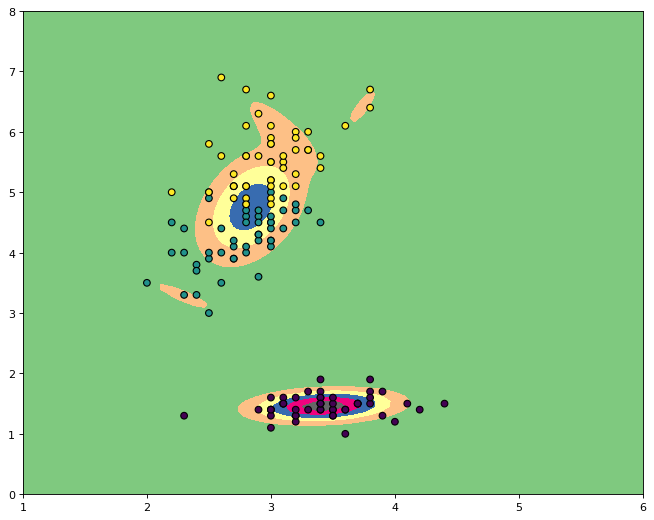

In [7]:
# 计算混合模型中的概率
def mixture(x):
    return sum(alpha[i]*Gaussian(x,means[i],covs[i])
              for i in range(len(alpha)))

n = 100
xx = np.linspace(1, 6, n)
yy = np.linspace(0, 8, n)

XX, YY = np.meshgrid(xx, yy)

ZZ = np.zeros_like(XX)
for i in range(n):
    for j in range(n):
        ZZ[i][j] = mixture(np.array([XX[i][j],YY[i][j]]))

plt.figure(figsize=(10,8), dpi=80)

plt.contourf(XX, YY, ZZ,cmap=plt.cm.Accent)
plt.scatter(X[:,1], X[:,2],edgecolors='black',
            c=y)
plt.show()

### 判别模型与生成模型
EM算法得到的模型是几个高斯分布，它能解释"数据是怎么来的"，这种模型既可以判别数据的类别，也可以生成数据。我们之前学习的逻辑回归，SVM等可以分类数据，但本质上只是一个函数或者条件概率分布，它得到的模型是P(C|X)，根据特征判别类别的函数，是后验概率。而生成式模型本质上做了P(X,Y)的工作，联合概率分布能直接解释"生成"(X,Y)样本的概率。  
生成式模型的可解释性也许要更好一些，因为它更接近数据的本质。今天有很多能把生成数据做得很好的模型，比如GAN和VAE，它们的本质也是像GMM一样，是用神经网络来近似一个联合概率分布P(X,Y)，GAN和VAE中，因为不容易定义类别，Y的一项由我们自己定义。

### 从GMM中采样
如果分布函数P = f(X)可以写成X = g(P)的形式，则采样是简单的。一些比较简单的分布函数有这样的性质，比如指数分布和均匀分布。
$$ p(X,\lambda) = \lambda exp(-\lambda X) \qquad \qquad X = \frac{1}{\lambda}log(\frac{\lambda}{p})$$
$$ p(X, a, b) = \frac{1}{b-a} \quad (a<x<b) \qquad \qquad X = a + p(b-a)$$
我们生成一个0到1的随机浮点数，就能很容易的完成采样。然而高斯分布，以及一些更复杂的模型似乎没办法这么轻松。一种解决方法是拒绝采样，我们用简单的，易采样的，和目标分布类似的提议分布中采样，然后把采样得到的数值代入目标概率分布，按照计算的p进行排斥和接纳(noise$<$p接纳，$>$p拒绝)。
很显然，提议分布的质量直接影响了采样的效率，如果两个分布非常不相似，则我们可能会进行很多的无效采样。

In [8]:
# 比如说，我们对上面学习到的GMM模型，可以按照我们的视觉先验知识，在区域内进行均匀分布的采样

n = 800
X1 = 1 + np.random.rand(n)*(6-1)
X2 = 0 + np.random.rand(n)*(8-0)

X = np.concatenate((X1[np.newaxis,:],X2[np.newaxis,:]),axis = 0)
X = X.T

In [9]:
accepted = []

for x in X:
    if np.random.random()/10<mixture(x):
        accepted.append(x)

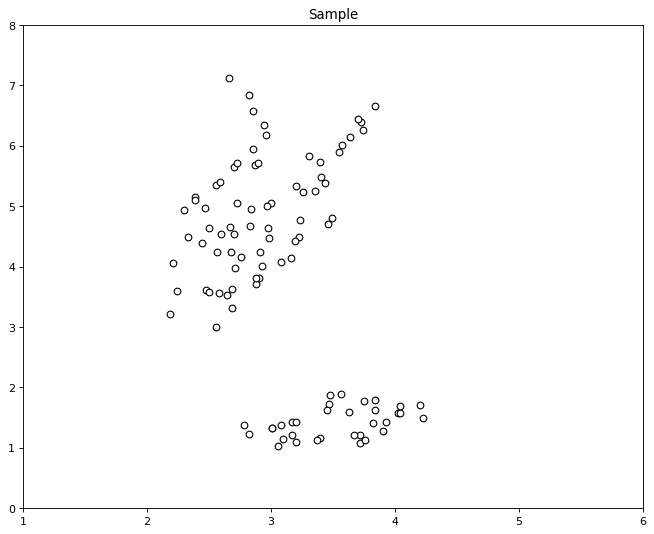

In [10]:
accepted = np.array(accepted)
plt.figure(figsize=(10,8), dpi=80)
plt.scatter(accepted[:,0], accepted[:,1],edgecolors='black',
            c='w')
plt.axis((1,6,0,8))
plt.title("Sample")
plt.show()